# Data anamnesis with Metacrate

This notebook showcases how to carry out a [data anamnesis](http://sites.computer.org/debull/A16june/p8.pdf) with Metacrate. In few words, we aim at building an initial understanding of a dataset and assessing its schema quality.

## Initialization

We have to start with some technical preparation. In particular, we need to load Metacrate and its dependencies into this notebook. Furthermore, we have to import the relevant packages into our namespace.

In [1]:
// For development: Register the local Maven repository to load snapshot versions of Metacrate.
locally {
    val m2Resolver = ammonite.runtime.tools.Resolver.File(
        "m2", "/.m2/repository", ammonite.runtime.tools.Resolvers.MavenPattern, true
    )
    interp.resolvers.update(interp.resolvers() ++ Seq(m2Resolver))
}

In [2]:
// Configure the logging (SLF4J).
System.setProperty("org.slf4j.simpleLogger.defaultLogLevel", "info")
System.setProperty("org.slf4j.simpleLogger.logFile", "tmp/data-anamnesis.log")
import $ivy.`org.slf4j:slf4j-simple:1.7.13`
val logger = org.slf4j.LoggerFactory.getLogger("data-anamnesis")
logger.info("Loading data-anamnesis notebook...")

res1_0: String = null
res1_1: String = null
import $ivy.$                              

logger: org.slf4j.Logger = org.slf4j.impl.SimpleLogger(data-anamnesis)

In [3]:
// Import required libs into the notebook.
import $ivy.`de.hpi.isg:mdms-jupyter:0.0.3-SNAPSHOT`,
       $ivy.`de.hpi.isg:mdms-tools:0.0.3-SNAPSHOT`,
       $ivy.`de.hpi.isg:mdms-analytics:0.0.3-SNAPSHOT`

// Import the packages.
import de.hpi.isg.mdms.jupyter._
import de.hpi.isg.mdms.analytics._
import de.hpi.isg.mdms.tools._
import de.hpi.isg.mdms.domain.constraints._
import de.hpi.isg.mdms.model.constraints._
import org.qcri.rheem.api._, org.qcri.rheem.core.api._, org.qcri.rheem.java._
import scala.collection.JavaConversions._

import $ivy.$                                       ,
       $ivy.$                                     ,
       $ivy.$                                         

// Import the packages.

import de.hpi.isg.mdms.jupyter._

import de.hpi.isg.mdms.analytics._

import de.hpi.isg.mdms.tools._

import de.hpi.isg.mdms.domain.constraints._

import de.hpi.isg.mdms.model.constraints._

import org.qcri.rheem.api._, org.qcri.rheem.core.api._, org.qcri.rheem.java._

import scala.collection.JavaConversions._

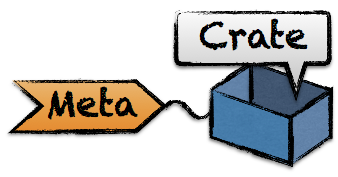

In [4]:
// See if Metacrate is properly loaded
output.showLogo()

## Configuration

At this point, we centralize all the configuration variables of this notebook for your convenience.

In [5]:
// Define the configuration options.
case class Profiles(location: String, 
                    filePattern: String = ".+", 
                    fileType: Import.MetanomeFormat = Import.JsonMetanomeFormat)

case class Dataset(name: String, 
              basedir: String,
              separator: String,
              quote: String,
              hasHeaders: Boolean) {
    def statistics = Profiles(location = s"$basedir/metanome")
    def uccs =       Profiles(location = s"$basedir/metanome",
                              filePattern = ".+_uccs")
    def fds =        Profiles(location = s"$basedir/metanome",
                              filePattern = ".+_fds")
    def inds =       Profiles(location = s"$basedir/metanome",
                              filePattern = ".+_inds")
    def location = s"$basedir/data"
    def sqlFile = s"$basedir/schema.sql"
}

object BiosqlSP extends Dataset(name = "BioSQL-SP",
                              basedir = "biosqlsp",
                              separator = ";",
                              quote = "\"",
                              hasHeaders = false)

object MusicBrainz extends Dataset(name = "MusicBrainz (core)",
                              basedir = "musicbrainz",
                              separator = ";",
                              quote = "\"",
                              hasHeaders = false)

defined class Profiles
defined class Dataset
defined object BiosqlSP
defined object MusicBrainz

In [6]:
// Pick an actual configuration.
object Configuration {
    // No internet access?
    offline = false
    // Which dataset to analyze?
    def dataset: Dataset = BiosqlSP
    // Where to store the data profiles?
    def storageBackend = SqliteBackend(location = s"${dataset.basedir}/data-anamnesis.db")
    // How to initialize metacrate?
    // csv: Obtain schema information from CSV files.
    // sql: Obtain schema information from SQL file.
    // reload: Don't initialize Metacrate, reuse an existing instance.
    def createFrom = "reload"
}

defined object Configuration

## Preparation

As a first step, we need to obtain an instance of Metacrate that is populated with metadata. This is the basis of all further analyses.

*Option 1.* We can choose to build a completely new Metacrate instance. In that case, we have to
1. initialize an empty instance,
2. load the schema information, and
3. load the relevant data profiles.

*Option 2.* Of course, we can just reload an existing Metacrate instance.

In [7]:
// Create a new Metacrate instance or load one.
implicit var metacrate = 
    if (Configuration.createFrom != "reload")
        createMetacrate(storageBackend = Configuration.storageBackend, isOverwrite = true)
    else
        loadMetacrate(storageBackend = Configuration.storageBackend)

// Initialize Rheem, which serves Metacrate as execution engine.
implicit val rheemCtx = new RheemContext() withPlugin Java.basicPlugin

metacrate: de.hpi.isg.mdms.model.MetadataStore = MetadataStore[SQLiteInterface[class org.sqlite.SQLiteConnection]]
rheemCtx: RheemContext = org.qcri.rheem.core.api.RheemContext@328a08fb

In [8]:
// Initialize the schema.
Configuration.createFrom match {
    case "csv" =>
        Import.createSchemaFromCsvFiles(
            schemaName = Configuration.dataset.name,
            fileLocation = Configuration.dataset.location,
            fieldSeparator = Configuration.dataset.separator,
            quoteChar = Configuration.dataset.quote,
            hasHeader = Configuration.dataset.hasHeaders,
            sqlFile = Configuration.dataset.sqlFile
        )
    case "sql" =>
        Import.createSchemaFromSqlFile(
            schemaName = Configuration.dataset.name,
            sqlFileLocation = Configuration.dataset.sqlFile
        )
    case "reload" =>
        // nothing to do 
}
val schema = metacrate.getSchemaByName(Configuration.dataset.name)

res7_0: Any = ()
schema: de.hpi.isg.mdms.model.targets.Schema = Schema[BioSQL-SP, , 0fffffff]

In [9]:
if (Configuration.createFrom != "reload") {
    // Import statistics from Metanome.
    Import.importMetanomeStatistics(
        fileLocation = Configuration.dataset.statistics.location,
        userDefinedIdPrefix = "metanome-",
        schema = schema
    )
    // Import dependencies from Metanome.
    Import.importMetanomeDependencies[UniqueColumnCombination](
        fileLocation = Configuration.dataset.uccs.location,
        fileType = Configuration.dataset.uccs.fileType,
        filePattern = Configuration.dataset.uccs.filePattern,
        userDefinedIdPrefix = "metanome-",
        schema = schema
    )
    Import.importMetanomeDependencies[FunctionalDependency](
        fileLocation = Configuration.dataset.fds.location,
        fileType = Configuration.dataset.fds.fileType,
        filePattern = Configuration.dataset.fds.filePattern,
        userDefinedIdPrefix = "metanome-",
        schema = schema
    )
    Import.importMetanomeDependencies[InclusionDependency](
        fileLocation = Configuration.dataset.inds.location,
        fileType = Configuration.dataset.inds.fileType,
        filePattern = Configuration.dataset.inds.filePattern,
        userDefinedIdPrefix = "metanome-",
        schema = schema
    )
}

In [10]:
if (Configuration.createFrom != "reload" && Configuration.dataset.sqlFile != null) {
    // If available, we can also import constraints from SQL definitions.
    Import.importPrimaryKeyDefinitions(sqlFile = Configuration.dataset.sqlFile,
                                       schema = schema,
                                       userDefinedId = "sql-primary-keys")
    Import.importForeignKeyDefinitions(sqlFile = Configuration.dataset.sqlFile,
                                       schema = schema,
                                       userDefinedId = "sql-foreign-keys")
}

## Analytics

At last, we arrive at the interesting part of this notebook. In the following, we are going to query and analyze the data profiles stored in our Metacrate instance, _with a specific focus on data anamnesis._

### Metadata overview

Let us start by summarizing the data profiles loaded into Metacrate.

In [11]:
// List the data profile collections in our Metacrate instance.
output.table(
    elements = iterableAsScalaIterable(metacrate.getConstraintCollections),
    columns = Seq("ID" -> ((cc: ConstraintCollection[_]) => cc.getId),
                  "User ID" -> ((cc: ConstraintCollection[_]) => Option(cc.getUserDefinedId) getOrElse "n/a"),
                  "Type" -> ((cc: ConstraintCollection[_]) => cc.getConstraintClass.getSimpleName),
                  "Description" -> ((cc: ConstraintCollection[_]) => cc.getDescription),
                  "Data profiles [#]" -> ((cc: ConstraintCollection[_]) => cc.getConstraints.size)
    )
)

ID,User ID,Type,Description,Data profiles [#]
944980,metanome-column-stats,ColumnStatistics,Statistics for BioSQL-SP (column statistics),74
71369047,metanome-uccs,UniqueColumnCombination,UCC import (Tue Nov 07 10:56:06 SGT 2017),31
210147739,metanome-text-stats,TextColumnStatistics,Statistics for BioSQL-SP (text statistics),12
578737795,table-cluster-k3,TableClusterAssignment,(no description),28
677583052,table-similarity,TableSimilarity,(no description),91
733650625,metanome-datatypes,TypeConstraint,Statistics for BioSQL-SP (type constraints),74
886442569,foreign-keys,InclusionDependency,Automatically classified foreign keys,29
908088541,metanome-fds,FunctionalDependency,FD import (Tue Nov 07 10:56:06 SGT 2017),92
973591367,sql-primary-keys,UniqueColumnCombination,Primary keys loaded from biosqlsp/schema.sql,24
1289163590,metanome-number-stats,NumberColumnStatistics,Statistics for BioSQL-SP (number statistics),43


In [12]:
// Count the number of data profiles.
locally {
    // Query.
    val numFDs = query { implicit engine =>
        val ccs = metacrate.getIncludedConstraintCollections(classOf[FunctionalDependency], schema).toSeq
        if (ccs.isEmpty) 0
        else metacrate.loadConstraints(ccs: _*).count.collect().head.toInt
    }
    val numUCCs = query { implicit engine =>
        val ccs = metacrate.getIncludedConstraintCollections(classOf[UniqueColumnCombination], schema).toSeq
        if (ccs.isEmpty) 0
        else metacrate.loadConstraints(ccs: _*).count.collect().head.toInt
    }
    val numINDs = query { implicit engine =>
        val ccs = metacrate.getIncludedConstraintCollections(classOf[InclusionDependency], schema).toSeq
        if (ccs.isEmpty) 0
        else metacrate.loadConstraints(ccs: _*).count.collect().head.toInt
    }
    
    // Plot.
    visualizations.plotBarChart(
        data = Seq("UCCs" -> numUCCs, "FDs" -> numFDs, "INDs" -> numINDs),
        title = "Number of data profiles",
        xaxisTitle = "Data profile type",
        yaxisTitle = "Data profiles [#]"
    )
}

### Data set size.

As a very first step to get familiar with a dataset, it makes sense to look at "how large" it is.
That includes questions, such as "How many tables are there?", "How many columns/rows do the tables contain?", or "What are the largest tables?"

We investigate these points with the following queries.

In [13]:
// How many columns are there in the tables?
query { implicit engine =>
    val idUtils = metacrate.getIdUtils

    // Query.
    metacrate.loadColumns(schema)
        .map(column => (idUtils.getTableId(column.id), 1))
        .reduceByKey(_._1, (a, b) => (a._1, a._2 + b._2))
        .resolveIds((count, r) => (r(count._1), count._2))
}
// Plot.
.plotBarChart(title = "Number of columns per table", 
              xaxisTitle = "Table",
              yaxisTitle = "Columns [#]",
              ordering = Ordering.by(_._2))

In [14]:
// How many tuples are there in the tables?
// (1) Query.
query { implicit engine =>
    metacrate.loadConstraints[TupleCount](schema)
        .resolveIds((tupleCount, r) => 
                    (r(tupleCount.getTableId), tupleCount.getNumTuples))       
}
// (2) Plot.
.plotBarChart(title = "Number of tuples per table", 
              xaxisTitle = "Table",
              yaxisTitle = "Tuples [#]",
              ordering = Ordering.by(_._2))

In [15]:
// How do the numbers of columns and tuples in the tables correlate?
query { implicit engine =>
    val idUtils = metacrate.getIdUtils
    import idUtils._
    
    // Query.
    val cols = metacrate.loadColumns(schema)
        .map(col => (getTableId(col.id), 1))
        .reduceByKey(_._1, (cnt1, cnt2) => (cnt1._1, cnt1._2+cnt2._2))
    val rows = metacrate.loadConstraints[TupleCount](schema)
    
    cols.keyBy(_._1).coGroup(rows.keyBy(_.getTableId))
        .map { coGroup => 
              val (cols, rows) = (coGroup.field0, coGroup.field1)
              (cols.head._2, // number of columns
               rows.map(_.getNumTuples.toInt).headOption getOrElse 0, // number of tuples
               cols.head._1)
        }
        .resolveIds((counts, r) => (counts._1, counts._2, r(counts._3)))
}
.plotScatterChart(title = "Number of rows vs. number of columns",
                  xaxisTitle = "Columns [#]",
                  yaxisTitle = "Rows [#]"
)

### Schema reconstruction


Many data formats, such as CSV files, are not capable of storing advanced schema information. As an example, often primary and foreign keys are missing. Nonetheless, such constraints can also be missing due to other reasons. Often foreign keys are not annotated because DB administrators fear the performance impact of FK enforcment.

In [16]:
// Reconstruct primary keys.
query { implicit engine =>   
    DependencyClassifiers.classifyPrimaryKeys(
        uccs = metacrate.getConstraintCollection[UniqueColumnCombination]("metanome-uccs"),
        statistics = metacrate.findConstraintCollection[ColumnStatistics](schema),
        textStatistics = metacrate.findConstraintCollection[TextColumnStatistics](schema)
    )  
    .storeConstraintCollection(scope = List(schema),
                               userDefinedId = "primary-keys",
                               description = "Automatically classified primary keys",
                               overwrite = true)
}

res15: ConstraintCollection[UniqueColumnCombination] = RDBMSConstraintCollection [scope=[Schema[BioSQL-SP, , 0fffffff]], getId()=1508947704]

In [17]:
query { implicit engine =>
    metacrate.loadConstraints[UniqueColumnCombination]("primary-keys")
        .resolveIds((pk, r) => s"${pk.getColumnIds.map(c => r(c)).mkString(",")}")
}
.printList(before = "<b>Automatically classified primary keys:</b>")

Automatically classified primary keys: bioentry_reference.bioentry_id,bioentry_reference.start_pos bioentry.bioentry_id bioentry_qualifier_value.bioentry_id,bioentry_qualifier_value.term_id,bioentry_qualifier_value.value seqfeature.seqfeature_id location.location_id comment.comment_id reference.reference_id biosequence.bioentry_id biodatabase.biodatabase_id term.term_id ontology.ontology_id bioentry_dbxref.bioentry_id,bioentry_dbxref.dbxref_id seqfeature_qualifier_value.seqfeature_id dbxref.dbxref_id taxon_name.taxon_id,taxon_name.name

In [18]:
// Reconstruct foreign keys.
query { implicit engine => 
    DependencyClassifiers.classifyForeignKeys(
        inds = metacrate.getConstraintCollection[InclusionDependency]("metanome-inds"),
        uccs = List(metacrate.getConstraintCollection[UniqueColumnCombination]("primary-keys")),
        tupleCounts = metacrate.findConstraintCollections[TupleCount](schema),
        statistics = metacrate.findConstraintCollections[ColumnStatistics](schema),
        textStatistics = metacrate.findConstraintCollections[TextColumnStatistics](schema)
    )
    .storeConstraintCollection(scope = List(schema),
                               userDefinedId = "foreign-keys",
                               description = "Automatically classified foreign keys",
                               overwrite = true)
}

res17: ConstraintCollection[InclusionDependency] = RDBMSConstraintCollection [scope=[Schema[BioSQL-SP, , 0fffffff]], getId()=1726704108]

In [19]:
query { implicit engine =>
    metacrate.loadConstraints[InclusionDependency]("foreign-keys")
        .resolveIds((ind, r) => (s"${ind.getDependentColumnIds.map(c => r(c)).mkString(",")}",
                                s"${ind.getReferencedColumnIds.map(c => r(c)).mkString(", ")}"))
}
.printList(before = "<b>Automatically classified foreign keys:</b>",
           format = { case (fk, ref) => s"$fk &rarr; $ref" })

Automatically classified foreign keys: location.rank → location.location_id bioentry_reference.bioentry_id → bioentry.bioentry_id seqfeature_qualifier_value.term_id → term.term_id seqfeature.rank → term.term_id seqfeature.source_term_id → biosequence.bioentry_id biosequence.version → comment.comment_id biodatabase.description → comment.comment_id location.end_pos → seqfeature.seqfeature_id bioentry.taxon_id → location.location_id term.identifier → comment.comment_id seqfeature.type_term_id → bioentry.bioentry_id bioentry_dbxref.dbxref_id → biosequence.bioentry_id bioentry_qualifier_value.bioentry_id → biosequence.bioentry_id reference.crc → dbxref.dbxref_id seqfeature.display_name → term.term_id location.strand → biosequence.bioentry_id ontology.definition → comment.comment_id biodatabase.authority → comment.comment_id bioentry_reference.reference_id → reference.reference_id term.ontology_id → ontology.ontology_id comment.rank → biosequence.bioentry_id biosequence.bioentry_id → bioentry.bioentry_id term.definition → reference.reference_id bioentry.description → biodatabase.biodatabase_id bioentry_qualifier_value.term_id → term.term_id bioentry.bioentry_id → biosequence.bioentry_id term.is_obsolete → comment.comment_id bioentry_dbxref.bioentry_id → dbxref.dbxref_id seqfeature_qualifier_value.seqfeature_id → seqfeature.seqfeature_id

### Conceptualization (Table Importance)

Besides the reconstruction of a technical (i.e., machine-readable) schema, it is also important for data practitioners to **understand** the data.
Here, we demonstrate a few opportunities of data profiles to better understand datasets.

At first, we aim to discover important tables.

In [20]:
// Display tables by their "information content" and "information transfer".
locally {
    val transitions = query { implicit engine =>
        TableImportance.calculateTableTransitions(
            columnStatistics = metacrate.findConstraintCollection[ColumnStatistics](schema),
            tupleCounts = metacrate.findConstraintCollection[TupleCount](schema),
            foreignKeys = metacrate.getConstraintCollection[InclusionDependency]("sql-foreign-keys")
        )
            .resolveTableIds(_.source, (trans, table) => (table.name, trans.dest, trans.probability))
            .resolveTableIds(_._2, (trans, table) => (trans._1, table.name, trans._3))
            .map(trans => Transition(trans._1, trans._2, trans._3))
    }
                             
    val groups = query { implicit engine =>
        TableImportance.calculateInformationContent(
            columnStatistics = metacrate.findConstraintCollection[ColumnStatistics](schema),
            tupleCounts = metacrate.findConstraintCollection[TupleCount](schema)
        )
            .resolveTableIds(_._1, (ic, table) => Category(name = table.name, weight = ic._2))
    }
    
    transitions.plotChordDiagram(groups = groups, scaleByGroups = true)
}

In [21]:
// Based on the information contents and transfers, assess the importances of the tables and store them.
query { implicit engine =>
    TableImportance.calculate(
        foreignKeys = metacrate.getConstraintCollection("sql-foreign-keys"),
        tupleCounts = metacrate.findConstraintCollection[TupleCount](schema),
        columnStatistics = metacrate.findConstraintCollection[ColumnStatistics](schema),
        iterations = 100
    )
}
//.printList()
 .storeConstraintCollection(scope = Seq(schema),
                            userDefinedId = "table-importances",
                            overwrite = true)

res20: ConstraintCollection[TableImportance] = RDBMSConstraintCollection [scope=[Schema[BioSQL-SP, , 0fffffff]], getId()=1902077385]

In [22]:
// Plot the tables and their importances in a schema graph.
locally {
    val tableImportances = query { implicit engine =>
        metacrate.loadConstraints[TableImportance]("table-importances")
            .resolveTableIds(_.tableId, { case (importance, table) => (table.name, importance.score) })
            .map { case (name, score) => GraphVertex(name, size=(math.max(2, math.sqrt(score))).toInt) }
    }.collect()

    val idUtils = metacrate.getIdUtils
    val foreignKeys = query { implicit engine =>
        metacrate.loadConstraints[InclusionDependency]("sql-foreign-keys")
            .map { case ind => (idUtils.getTableId(ind.getDependentColumnIds()(0)), 
                                idUtils.getTableId(ind.getReferencedColumnIds()(0))) }
            .resolveTableIds(_._1, {case (link, table) => (table.name, link._2)})
            .resolveTableIds(_._2, {case (link, table) => GraphEdge(link._1, table.name)})
    }.collect()

    visualizations.plotDirectedGraph(nodes = tableImportances,
                                    links = foreignKeys,
                                    height = "800px",
                                    charge = -800,
                                    linkDistance = 100)
}

Freeze 
  
 Link distance: 
  
 Charge:

## Conceptualization (Table Clustering)

While discovering important tables helps to conceptualize a schema in a bottom-up fashion, we can complement this with a top-down approach, where we break down the schema into clusters of tables.

In [23]:
// Based on the schema graph and some additional statistics, we can also assess the similarity of tables
// and store them in Metacrate.
query { implicit engine =>
    TableSimilarity.calculate(
        foreignKeys = metacrate.getConstraintCollection("sql-foreign-keys"),
        tupleCounts = metacrate.findConstraintCollection[TupleCount](schema),
        columnStatistics = metacrate.findConstraintCollection[ColumnStatistics](schema),
        transitiveHull = true
    )
}
.storeConstraintCollection(scope = Seq(schema),
                           userDefinedId = "table-similarity",
                           overwrite = true)

res22: ConstraintCollection[TableSimilarity] = RDBMSConstraintCollection [scope=[Schema[BioSQL-SP, , 0fffffff]], getId()=370450707]

In [28]:
// Lets visualize the table similarities in a matrix.
query { implicit engine =>
    metacrate.loadConstraints[TableSimilarity]("table-similarity")
        .resolveTableIds(_.tableId1, (sim, table) => (table.name, sim.tableId2, sim.similarity))
        .resolveTableIds(_._2, (sim, table) => (sim._1, table.name, sim._3))
        .flatMap { case (table1, table2, similarity) =>
            Seq(Tile(table1, table2, similarity), Tile(table2, table1, similarity))
        }
}
.plotGrid(width=700, height=700)

In [25]:
// The similarities and table importances can further be used to cluster the tables.
// We consider two different numbers of clusters and store the results.

query { implicit engine =>
    TableClustering.kWeightedCenter(
        similarities = metacrate.getConstraintCollection[TableSimilarity]("table-similarity"),
        importances = metacrate.getConstraintCollection[TableImportance]("table-importances"),
        k = 5
    )
}.storeConstraintCollection(scope = Seq(schema),
                            userDefinedId = "table-cluster-k5",
                            overwrite = true)

query { implicit engine =>
    TableClustering.kWeightedCenter(
        similarities = metacrate.getConstraintCollection[TableSimilarity]("table-similarity"),
        importances = metacrate.getConstraintCollection[TableImportance]("table-importances"),
        k = 3
    )
}.storeConstraintCollection(scope = Seq(schema),
                            userDefinedId = "table-cluster-k3",
                            overwrite = true)

res24_0: ConstraintCollection[TableClusterAssignment] = RDBMSConstraintCollection [scope=[Schema[BioSQL-SP, , 0fffffff]], getId()=81913777]
res24_1: ConstraintCollection[TableClusterAssignment] = RDBMSConstraintCollection [scope=[Schema[BioSQL-SP, , 0fffffff]], getId()=1276740434]

In [26]:
// Plot the clustering in a schema graph.
locally {
    val vertices = query { implicit engine =>
        val importances = metacrate.loadConstraints[TableImportance]("table-importances")
        val clustering = metacrate.loadConstraints[TableClusterAssignment]("table-cluster-k5")
        
        importances.keyBy(_.tableId).join(clustering.keyBy(_.tableId))
            .assemble { (imp, clust) => (imp.tableId, imp.score, clust.clusterId) }
            .resolveTableIds(_._1, { case (data, table) => 
                GraphVertex(name = table.name,
                            size = (math.max(2, math.sqrt(data._2))).toInt,
                            color = data._3
                )
            })
    }

    val idUtils = metacrate.getIdUtils
    val foreignKeys = query { implicit engine =>
        metacrate.loadConstraints[InclusionDependency]("sql-foreign-keys")
            .map { case ind => (idUtils.getTableId(ind.getDependentColumnIds()(0)), 
                                idUtils.getTableId(ind.getReferencedColumnIds()(0))) }
            .resolveTableIds(_._1, {case (link, table) => (table.name, link._2)})
            .resolveTableIds(_._2, {case (link, table) => GraphEdge(link._1, table.name)})
    }
    
    foreignKeys.plotDirectedGraph(nodes = vertices,
                                  height = "400px",
                                  charge = -1000,
                                  linkDistance = 200)
}

Freeze 
  
 Link distance: 
  
 Charge:

In [29]:
// We can also combine the clustering with the table similarities in a matrix.
locally {
    val tiles = query { implicit engine =>
        val similarities = metacrate.loadConstraints[TableSimilarity]("table-similarity")
        val clustering = metacrate.loadConstraints[TableClusterAssignment]("table-cluster-k5")
        val diagonalTiles = clustering.resolveIds { case (assignment, r) =>
            Tile(row=r(assignment.tableId), column=r(assignment.tableId), opacity=1, color=assignment.clusterId+1)
        }
                       
        similarities.keyBy(_.tableId1).join(clustering.keyBy(_.tableId))
           .assemble { case (TableSimilarity(t1, t2, sim), TableClusterAssignment(_, cluster1, _)) =>
               (t1, t2, sim, cluster1)
           }
           .keyBy(_._2).join(clustering.keyBy(_.tableId))
           .assemble { case ((t1, t2, sim, cluster1), TableClusterAssignment(_, cluster2, _)) => 
               (t1, t2, sim, cluster1, cluster2)
           }
           .resolveTableIds(_._1, { case ((t1, t2, sim, cluster1, cluster2), table) =>
               (table.name, t2, sim, cluster1, cluster2)
           })
           .resolveTableIds(_._2, { case ((t1, t2, sim, cluster1, cluster2), table) =>
               (t1, table.name, sim, cluster1, cluster2)
           })
           .flatMap { case  (t1, t2, sim, cluster1, cluster2) =>
               val color = if (cluster1 == cluster2) cluster1 + 1 else 0
               Seq(Tile(row=t1, column=t2, opacity=0.8*sim+0.2, color=color),
                   Tile(row=t2, column=t1, opacity=0.8*sim+0.2, color=color)
               )
           }
           .union(diagonalTiles)
    }
    
    val rows = query { implicit engine =>
        metacrate.loadConstraints[TableClusterAssignment]("table-cluster-k5")
            .resolveTableIds(_.tableId, (clusterAssignment, table) => 
                             Category(name = table.name, order = clusterAssignment.clusterId)
            )
    }
    
    val columns = query { implicit engine =>
        metacrate.loadConstraints[TableClusterAssignment]("table-cluster-k5")
            .resolveTableIds(_.tableId, (clusterAssignment, table) => 
                             Category(name = table.name, order = clusterAssignment.clusterId)
            )
    }
    
    tiles.plotGrid(rows=rows, columns=columns, width=700, height=700)
}